# MAD - Projekt 2

TODO:
- [x] import danych
- [x] EDA
- [x] baseline model
- [x] test model
- [ ] funkcja do roc-ów
- [ ] ?

In [110]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import indent
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize

In [2]:
pd.set_option('max_rows', 8)
pd.set_option('max_columns', 33)
pd.options.display.float_format = '{0:.2f}'.format
colormap = plt.cm.bwr_r

## Przygotowanie danych

In [3]:
# import danych
data = pd.read_csv('dane/churn.csv', decimal=',')

### Analiza danych

In [4]:
def diffrent_values(col):
    len_val = len(data[col].value_counts(col))
    if len_val < 20:
        print("{} wartości kolumny {}:".format(len_val, col))
        print(indent(data[col].value_counts().to_string(), "    "))
        print()

In [5]:
# col_val = ['Promotion', 'Calls to data service (3 months ago)', 'Calls to data service (3 months ago)', 'Region', 'Cancelled']
for col in data.columns:
    diffrent_values(col)


2 wartości kolumny Churn (1=yes, 0=No):
    0    10629
    1     1181

2 wartości kolumny Cancelled:
    0    11571
    1      239

2 wartości kolumny Way of payment:
    Standing Order    11270
    Unknown             540

1 wartości kolumny Promotion:
    0    11810

11 wartości kolumny Region:
    5    1960
    4    1420
    7    1320
    3    1300
    8    1240
    2    1070
    6    1050
    9    1000
    1     850
    0     580
    F      20

5 wartości kolumny Profit segment:
    D    7140
    C    2240
    E    1360
    B     910
    A     160

2 wartości kolumny Sex:
    Male      8970
    Female    2840

9 wartości kolumny Tariff model:
    16    5340
    5     5270
    8      290
    4      230
    3      220
    1      170
    18     150
    17      80
    12      60

2 wartości kolumny Academic title:
    0    11520
    1      290

11 wartości kolumny Airtime to data service (1 month ago):
    0.00      11800
    98.32         1
    114.88        1
    104.62        1
    

In [6]:
data = data.drop('ID', axis=1)
# Promotion i 'Calls to data service (3 months ago)' posiada tylko jedną wartość
data = data.drop('Promotion', axis=1)
data = data.drop('Calls to data service (3 months ago)', axis=1)
# Airtime... posiada 99.9% wartości 0
data = data.drop('Airtime to data service (1 month ago)', axis=1)
# data.drop(data[data['Region'] == 'F'].index)

In [7]:
data.columns = data.columns.map(lambda x: 'Churn' if x == 'Churn (1=yes, 0=No)' else x)
data

,Churn,Profit,Age,Cancelled,Months since start,Way of payment,Region,Profit segment,Sex,Tariff model,Academic title,Revenue from calls (3 months ago),Fixed revenue (3 months ago),Revenue from roaming (3 months ago),Total revenue (3 months ago),Airtime incoming (1 month ago),Airtime to mobile (1 month ago),Calls incoming (3 months ago),Calls roaming (3 months ago)
0,0,25.41,21,0,14,Standing Order,0,D,Female,5,0,7.83,0.00,0.00,7.83,1105.41,439.86,75,0
1,1,572.11,29,0,26,Standing Order,7,B,Male,8,0,436.53,0.00,0.00,436.53,54991.23,44696.35,199,3
2,0,57.46,20,0,10,Standing Order,1,D,Female,5,0,69.88,28.12,0.00,98.00,684.39,651.22,54,0
3,1,292.60,47,1,29,Standing Order,5,A,Male,18,0,419.52,62.60,0.00,482.12,12523.26,4837.45,134,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11806,0,12.48,29,0,10,Standing Order,2,D,Male,5,0,5.66,30.71,0.00,36.37,7.01,0.00,3,0
11807,0,62.90,29,0,33,Standing Order,8,D,Male,5,0,51.29,28.12,0.00,79.41,191.59,424.00,14,0
11808,0,2.46,25,0,10,Standing Order,2,D,Female,5,0,23.47,4.89,0.00,28.36,155.68,90.85,1,0
11809,1,265.83,20,0,7,Standing Order,0,E,Male,16,0,38.35,28.12,0.00,66.47,19145.34,3600.64,76,0


In [8]:
col_label = [c for c in data.columns if data[c].dtype == 'object']
col_numerical = [c for c in data.columns if not data[c].dtype == 'object']

change = ['Cancelled', 'Tariff model', 'Academic title']
col_label.extend(change)
col_numerical.remove('Churn')
col_numerical = [c for c in col_numerical if not c in change]

col_PK = ['Profit', 'Fixed revenue (3 months ago)', 'Airtime incoming (1 month ago)',
          'Way of payment', 'Cancelled']

# col_label
# col_numerical

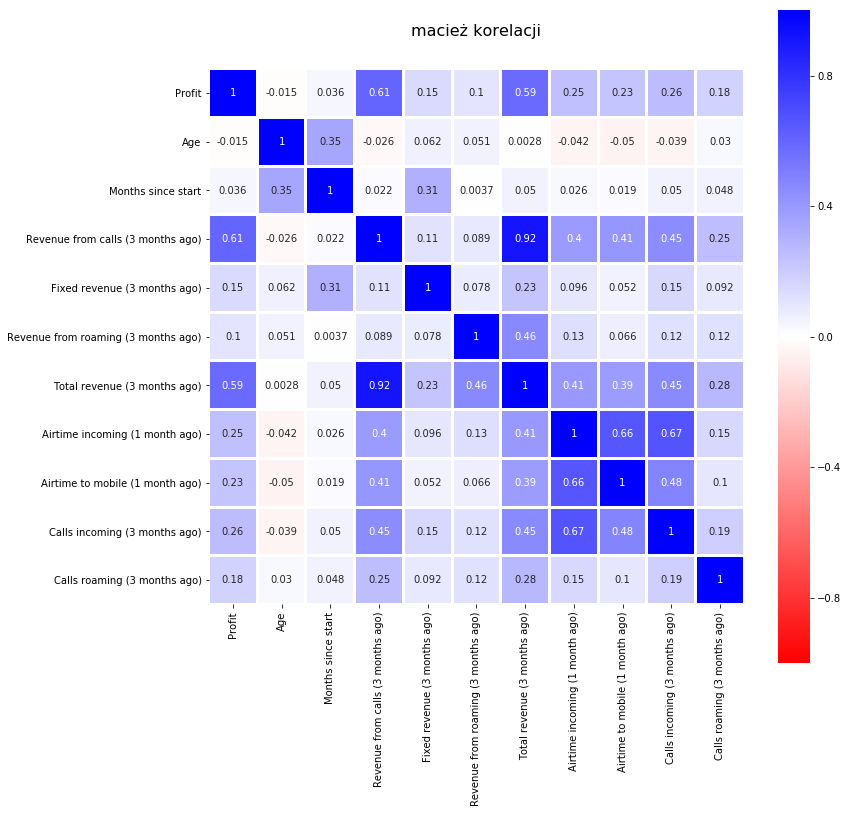

In [9]:
plt.figure(figsize=(12,12))
plt.title('macież korelacji', y=1.05, size=16)
sns.heatmap(data[col_numerical].astype(float).corr(), linewidths=2,  vmax=1.0, vmin = -1,
            square=True, cmap=colormap, annot=True)

In [10]:
def plot_cats(col_list, data):
    churn0 = data[data['Churn'] == 0]
    churn1 = data[data['Churn'] == 1]

    f, axes = plt.subplots(len(col_list), figsize=(10, 4*len(col_list))) 
    plt.subplots_adjust(hspace=0.3)
    
    i = 0
    for col in col_list:
        axes[i].set_title(col, size=16)
        sns.kdeplot(churn0[col], color=sns.xkcd_rgb["pale red"], label="0", ax = axes[i])
        sns.kdeplot(churn1[col], color=sns.xkcd_rgb["denim blue"], label="1", ax = axes[i])
        i += 1
    
#     sns.kdeplot(churn0['Profit'], label=0, ax = axes[0])
#     sns.kdeplot(churn1['Profit'], label=1 ,ax = axes[0])

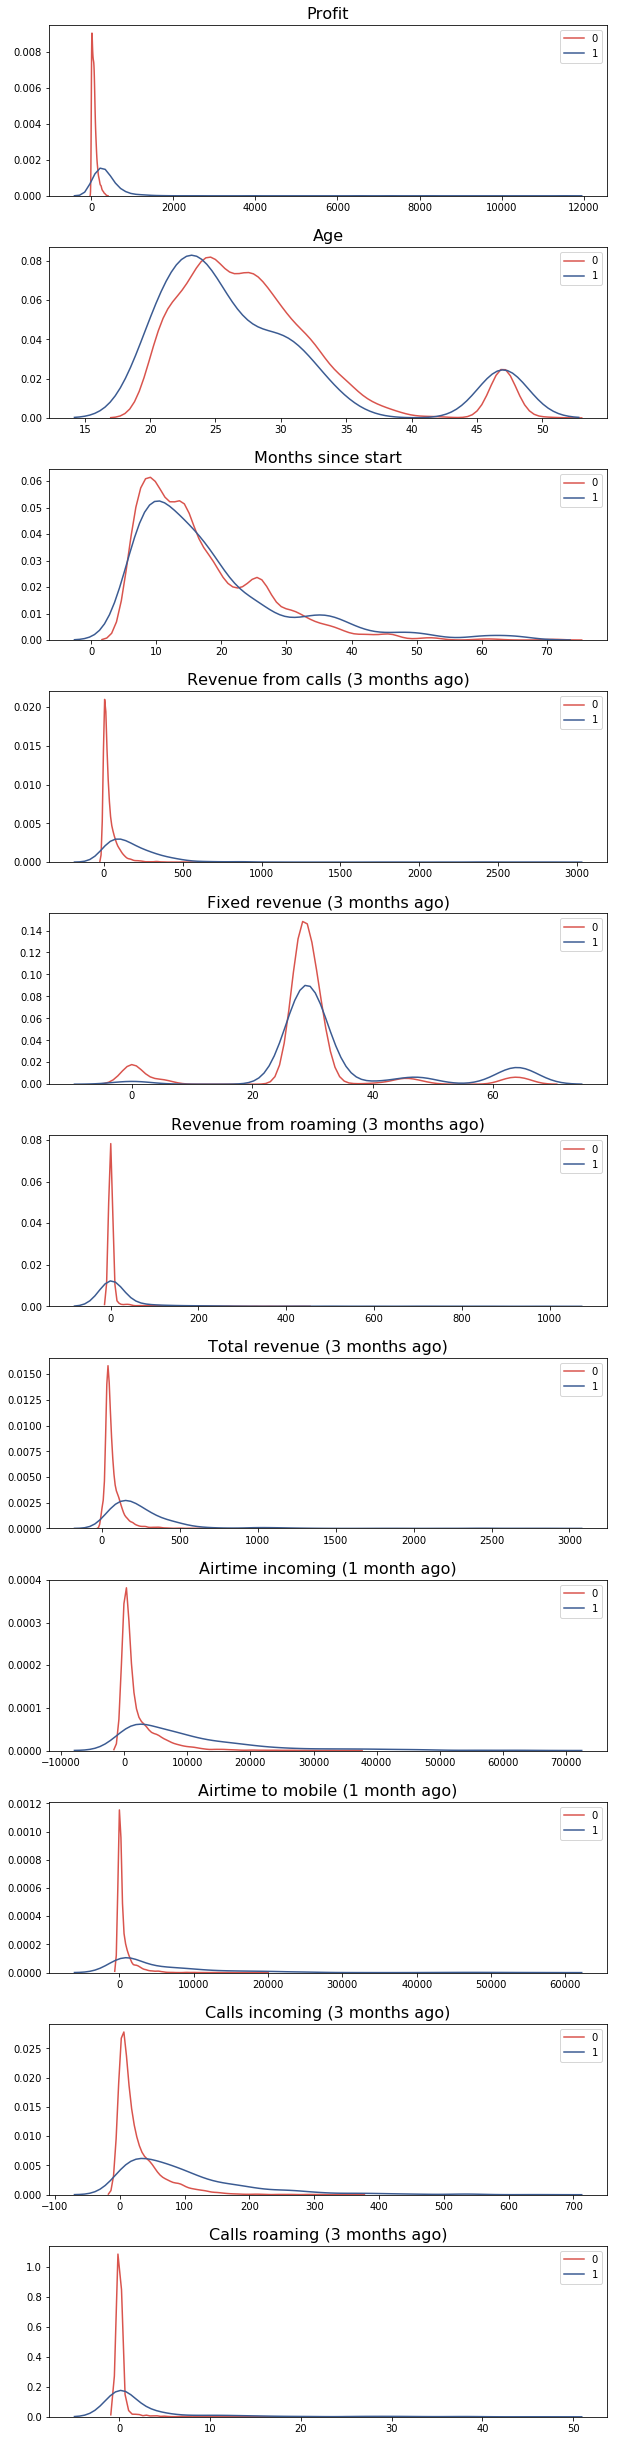

In [11]:
plot_cats(col_numerical, data)

### Podział na zbiór treningowy i testowy

In [26]:
X = data.drop('Churn', axis=1)
y = data.Churn

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 0)

## Modele

In [ ]:
def ROC

### Baseline model

In [13]:
data['Churn'].value_counts()

0    10629
1     1181
Name: Churn, dtype: int64

In [14]:
def baseline_model(X):
    return [0] * len(X)

In [15]:
a = 0
s = 0
for (a1, a2) in zip(baseline_model(data), data['Churn']) :
    s += 1
    if a1 == a2:
        a += 1
print("Baseline model accuracy: {}".format(a/s))

Baseline model accuracy: 0.9


### PK models

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense

/home/pkacz/nauka/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [30]:
train_X, test_X, train_y, test_y

(       Profit  Age  Cancelled  Months since start  Way of payment Region  \
 7317    54.31   33          0                  10  Standing Order      4   
 8986    27.91   29          0                  14  Standing Order      4   
 5306   101.68   20          0                  11  Standing Order      3   
 4339   120.95   47          0                  34  Standing Order      9   
 ...       ...  ...        ...                 ...             ...    ...   
 3264    52.03   22          0                  24  Standing Order      0   
 9845    20.26   21          0                   9  Standing Order      5   
 10799  173.60   22          0                   7  Standing Order      7   
 2732    43.44   21          0                   7  Standing Order      9   
 
       Profit segment   Sex  Tariff model  Academic title  \
 7317               D  Male             5               0   
 8986               D  Male             5               0   
 5306               D  Male             5    

In [49]:
train_X_PK = train_X[col_PK]
test_X_PK = test_X[col_PK]

train_X_PK = pd.get_dummies(train_X_PK)
test_X_PK = pd.get_dummies(test_X_PK)

In [46]:
train_X_PK

,Profit,Fixed revenue (3 months ago),Airtime incoming (1 month ago),Cancelled,Way of payment_Standing Order,Way of payment_Unknown
7317,54.31,30.71,824.62,0,1,0
8986,27.91,28.12,416.43,0,1,0
5306,101.68,30.71,6922.55,0,1,0
4339,120.95,28.12,11879.24,0,1,0
...,...,...,...,...,...,...
3264,52.03,28.12,7138.06,0,1,0
9845,20.26,28.12,336.55,0,1,0
10799,173.60,28.12,4188.58,0,1,0
2732,43.44,28.12,3242.94,0,1,0


#### Decision Tree

In [80]:
PK_model1 = DecisionTreeClassifier()
PK_model1.fit(train_X_PK, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [81]:
PK_model1.score(test_X_PK, test_y)

0.9217744666440908

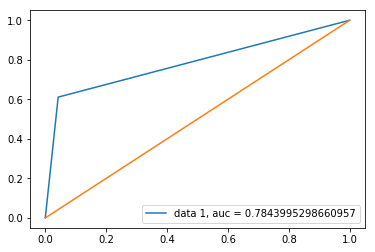

In [82]:
predicted_y_PK = PK_model1.predict_proba(test_X_PK)[:,1]
fpr, tpr, _ = roc_curve(test_y, predicted_y_PK)
auc = roc_auc_score(test_y, predicted_y_PK)
plt.plot(fpr,tpr,label="data, auc = {}".format(str(auc)))
plt.legend(loc=4)
plt.plot(tpr,tpr)

#### Random Forest

In [48]:
PK_model2 = RandomForestClassifier()
PK_model2.fit(train_X_PK, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
PK_model2.score(test_X_PK, test_y)

0.9414155096512021

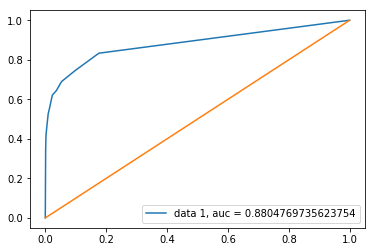

In [77]:
predicted_y_PK = PK_model2.predict_proba(test_X_PK)[:,1]
fpr, tpr, _ = roc_curve(test_y, predicted_y_PK)
auc = roc_auc_score(test_y, predicted_y_PK)
plt.plot(fpr,tpr,label="data, auc = {}".format(str(auc)))
plt.legend(loc=4)
plt.plot(tpr,tpr)

#### XGBoost

In [87]:
PK_model3 = XGBClassifier()
PK_model3.fit(train_X_PK, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [88]:
PK_model3.score(test_X_PK, test_y)

/home/pkacz/nauka/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9444632577040298

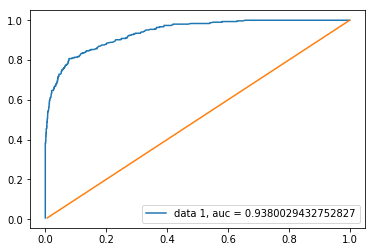

In [89]:
predicted_y_PK = PK_model3.predict_proba(test_X_PK)[:,1]
fpr, tpr, _ = roc_curve(test_y, predicted_y_PK)
auc = roc_auc_score(test_y, predicted_y_PK)
plt.plot(fpr,tpr,label="data, auc = {}".format(str(auc)))
plt.legend(loc=4)
plt.plot(tpr,tpr)

#### Neural Network

In [108]:
PK_model4 = Sequential()

PK_model4.add(Dense(units=32, activation='relu', input_dim=len(train_X_PK.T)))
PK_model4.add(Dense(units=32, activation='relu'))
PK_model4.add(Dense(units=1, activation='softmax'))

PK_model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [109]:
PK_model4.fit(train_X_PK, train_y, epochs=20, batch_size=128)

Epoch 1/20
8857/8857 [==============================] - 0s 38us/step - loss: 14.3674 - acc: 0.0988
Epoch 2/20
8857/8857 [==============================] - 0s 12us/step - loss: 14.3674 - acc: 0.0988
Epoch 3/20
8857/8857 [==============================] - 0s 12us/step - loss: 14.3674 - acc: 0.0988
Epoch 4/20
8857/8857 [==============================] - 0s 13us/step - loss: 14.3674 - acc: 0.0988
Epoch 5/20
8857/8857 [==============================] - 0s 13us/step - loss: 14.3674 - acc: 0.0988
Epoch 6/20
8857/8857 [==============================] - 0s 12us/step - loss: 14.3674 - acc: 0.0988
Epoch 7/20
8857/8857 [==============================] - 0s 13us/step - loss: 14.3674 - acc: 0.0988
Epoch 8/20
8857/8857 [==============================] - 0s 12us/step - loss: 14.3674 - acc: 0.0988
Epoch 9/20
8857/8857 [==============================] - 0s 12us/step - loss: 14.3674 - acc: 0.0988
Epoch 10/20
8857/8857 [==============================] - 0s 13us/step - loss: 14.3674 - acc: 0.0988
Epoch 11/

In [104]:
print(PK_model4.evaluate(test_X_PK, test_y))
PK_model4.metrics_names

2953/2953 [==============================] - 0s 22us/step
[14.290380269924826, 0.10362343379613952]


['loss', 'acc']